## Imports

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re
import time
from collections import Counter
import random
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

## Анализ

In [5]:
df = pd.read_csv('data/imdb_top_movies.csv')
print("Общая информация о датасете:")
print(f"Размерность: {df.shape}")
print("\nТипы данных:")
print(df.dtypes)
print("\nПервые 5 строк:")
print(df.head())

Общая информация о датасете:
Размерность: (250, 7)

Типы данных:
title           object
year           float64
rating         float64
genres          object
description     object
director        object
url             object
dtype: object

Первые 5 строк:
                      title  year  rating                genres  \
0  The Shawshank Redemption   NaN     9.3                 Drama   
1             The Godfather   NaN     9.2          Crime, Drama   
2           The Dark Knight   NaN     9.0  Action, Crime, Drama   
3     The Godfather Part II   NaN     9.0          Crime, Drama   
4              12 Angry Men   NaN     9.0          Crime, Drama   

                                         description              director  \
0  A banker convicted of uxoricide forms a friend...        Frank Darabont   
1  The aging patriarch of an organized crime dyna...  Francis Ford Coppola   
2  When a menace known as the Joker wreaks havoc ...     Christopher Nolan   
3  The early life and career

In [6]:
print("Количество пропущенных значений по столбцам:")
print(df.isnull().sum())

Количество пропущенных значений по столбцам:
title            0
year           249
rating           0
genres           0
description      0
director         0
url              0
dtype: int64


In [7]:
def parse_genres(genres_str):
    """Преобразует строку с жанрами в список"""
    if pd.isna(genres_str):
        return []
    return [genre.strip() for genre in genres_str.split(',')]

df['genres_list'] = df['genres'].apply(parse_genres)

all_genres = []
for genres in df['genres_list']:
    all_genres.extend(genres)

genre_counts = Counter(all_genres)
print("Топ-10 наиболее популярных жанров:")
for genre, count in genre_counts.most_common(10):
    print(f"{genre}: {count}")

Топ-10 наиболее популярных жанров:
Drama: 185
Adventure: 60
Crime: 52
Action: 46
Comedy: 46
Mystery: 31
Biography: 29
Thriller: 27
War: 25
Animation: 25



Статистика по рейтингам:
count    250.000000
mean       8.310000
std        0.233577
min        8.000000
25%        8.100000
50%        8.200000
75%        8.400000
max        9.300000
Name: rating, dtype: float64


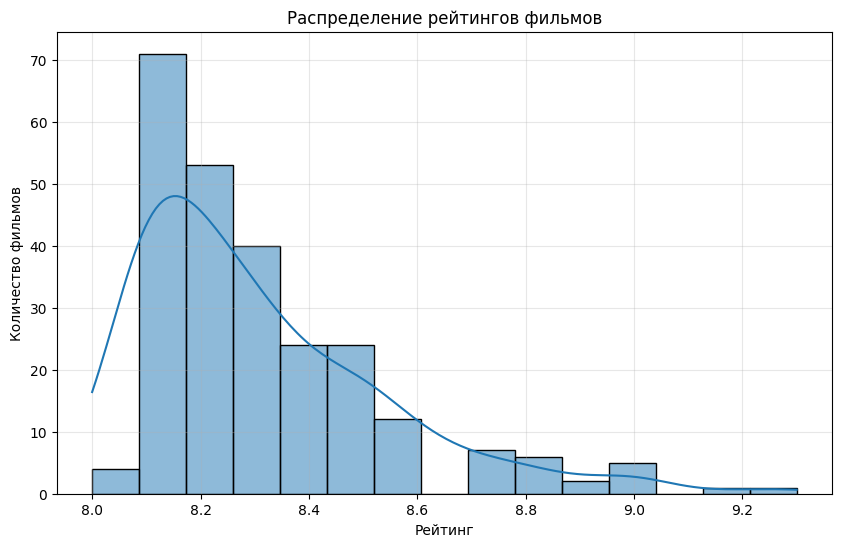

In [9]:
print("\nСтатистика по рейтингам:")
print(df['rating'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], kde=True, bins=15)
plt.title('Распределение рейтингов фильмов')
plt.xlabel('Рейтинг')
plt.ylabel('Количество фильмов')
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
df['description_length'] = df['description'].apply(len)

print("Статистика по длине описаний:")
print(df['description_length'].describe())

Статистика по длине описаний:
count    250.000000
mean     161.928000
std       43.681979
min       46.000000
25%      130.250000
50%      165.000000
75%      190.000000
max      240.000000
Name: description_length, dtype: float64


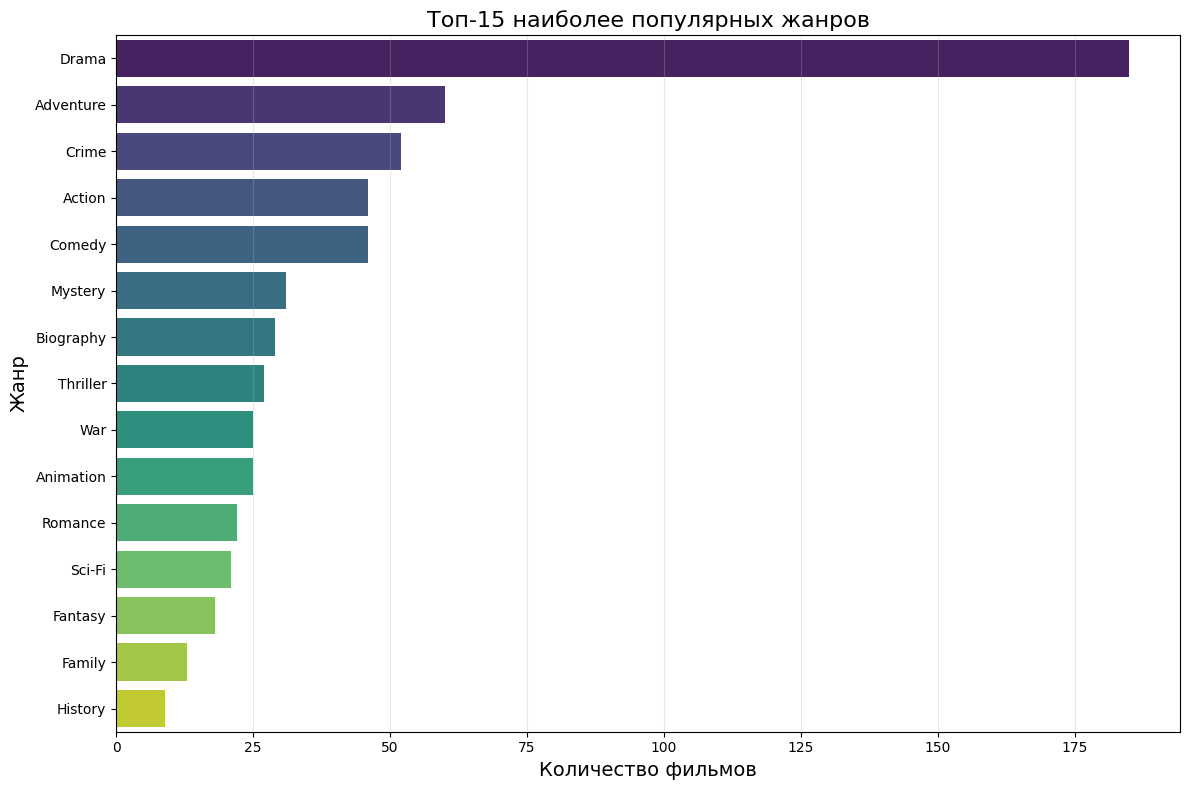

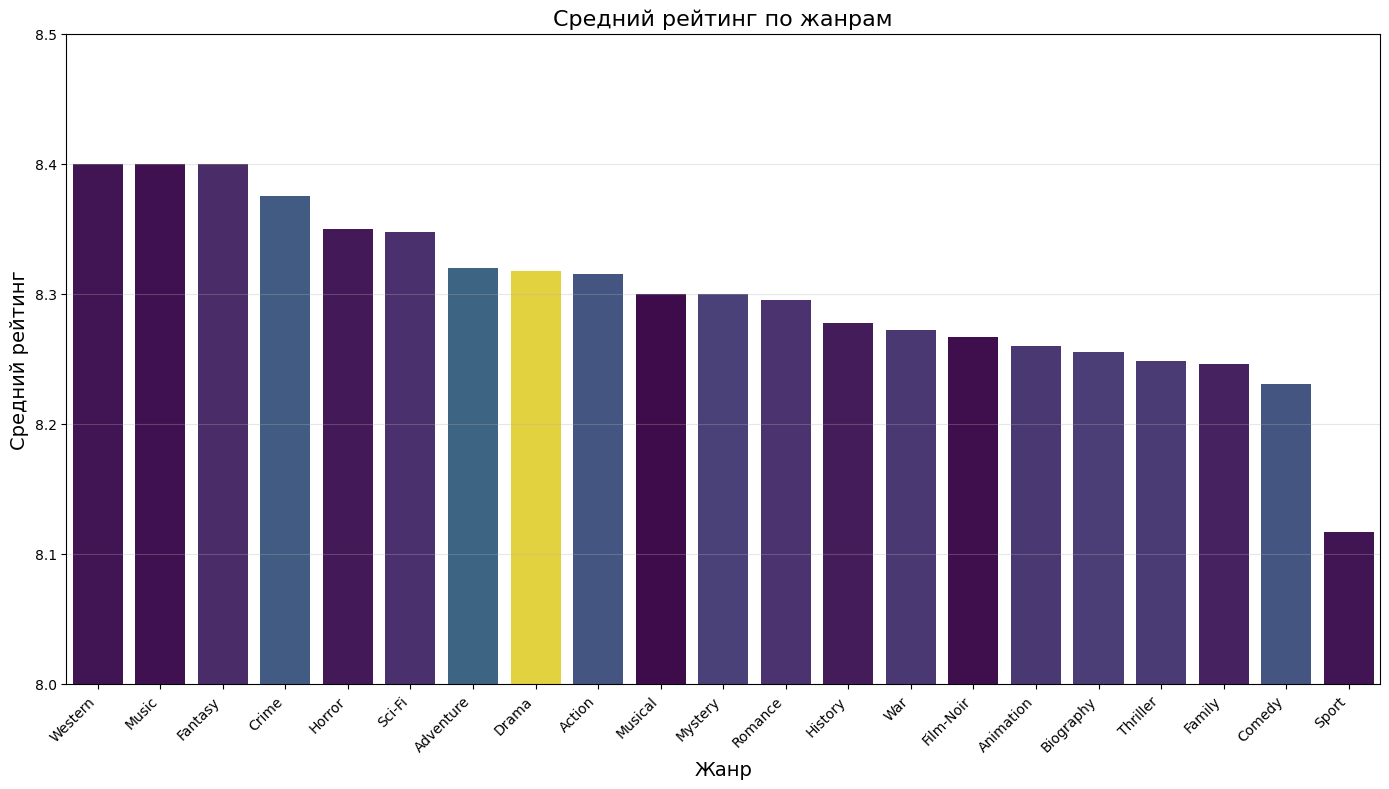

In [21]:
genres_df = pd.DataFrame({'genre': list(genre_counts.keys()), 'count': list(genre_counts.values())})
genres_df = genres_df.sort_values('count', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='genre', data=genres_df, palette='viridis')
plt.title('Топ-15 наиболее популярных жанров', fontsize=16)
plt.xlabel('Количество фильмов', fontsize=14)
plt.ylabel('Жанр', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

genre_ratings = {}

for genre in genre_counts.keys():
    # Фильтруем фильмы по жанру
    genre_films = df[df['genres_list'].apply(lambda x: genre in x)]
    avg_rating = genre_films['rating'].mean()
    genre_ratings[genre] = avg_rating

genre_ratings_df = pd.DataFrame({
    'genre': list(genre_ratings.keys()),
    'avg_rating': list(genre_ratings.values()),
    'count': [genre_counts[genre] for genre in genre_ratings.keys()]
})

genre_ratings_df = genre_ratings_df.sort_values('avg_rating', ascending=False)

plt.figure(figsize=(14, 8))
bars = sns.barplot(x='genre', y='avg_rating', data=genre_ratings_df,
                  palette='viridis', hue='count', dodge=False, legend=False)

plt.title('Средний рейтинг по жанрам', fontsize=16)
plt.xlabel('Жанр', fontsize=14)
plt.ylabel('Средний рейтинг', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(8.0, 8.5)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

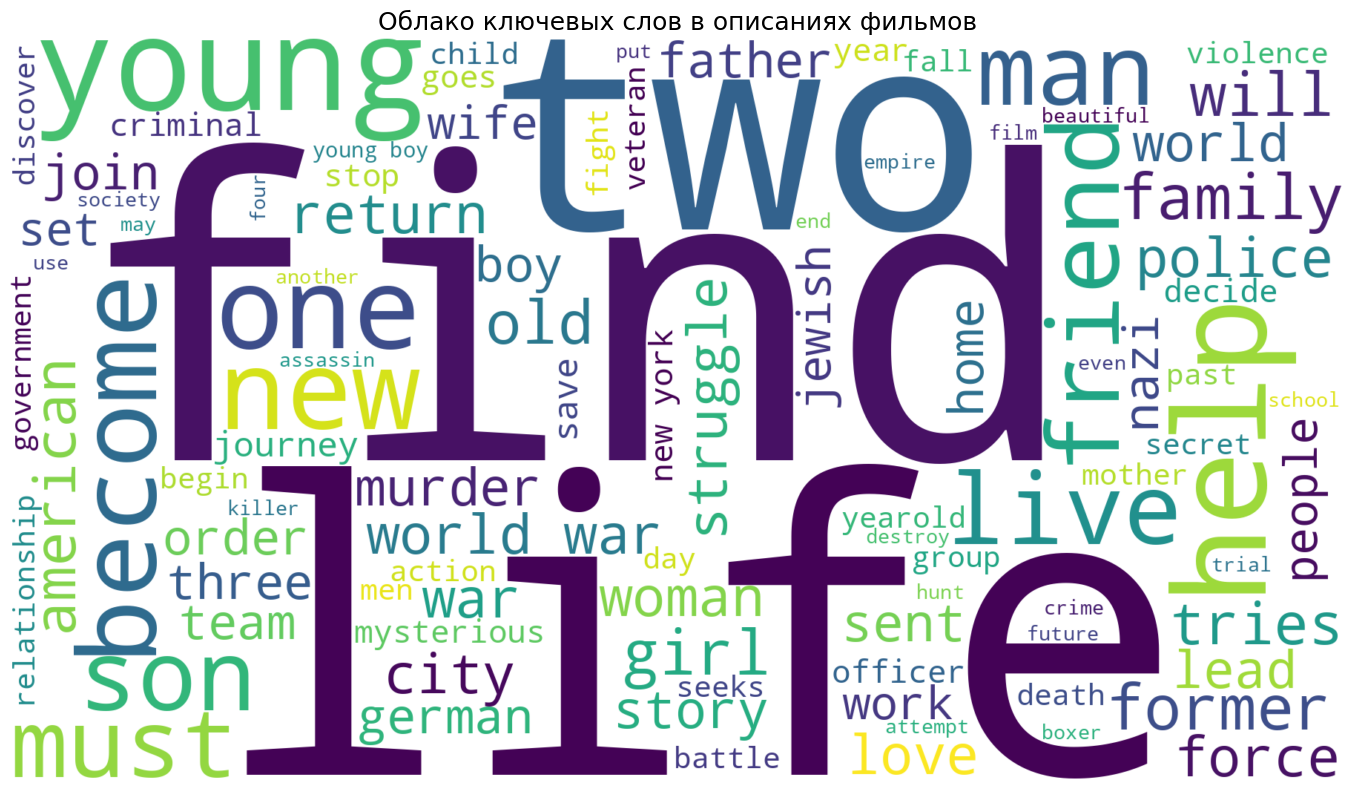

In [23]:
all_descriptions = ' '.join(df['description'].fillna(''))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = {'the', 'a', 'an', 'and', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'as', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'from', 'his', 'her', 'he', 'she', 'they', 'them', 'their', 'it', 'its'}
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

preprocessed_descriptions = preprocess_text(all_descriptions)

wordcloud = WordCloud(width=1800, height=1000, background_color='white', max_words=100, colormap='viridis').generate(preprocessed_descriptions)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако ключевых слов в описаниях фильмов', fontsize=18)
plt.tight_layout()
plt.show()

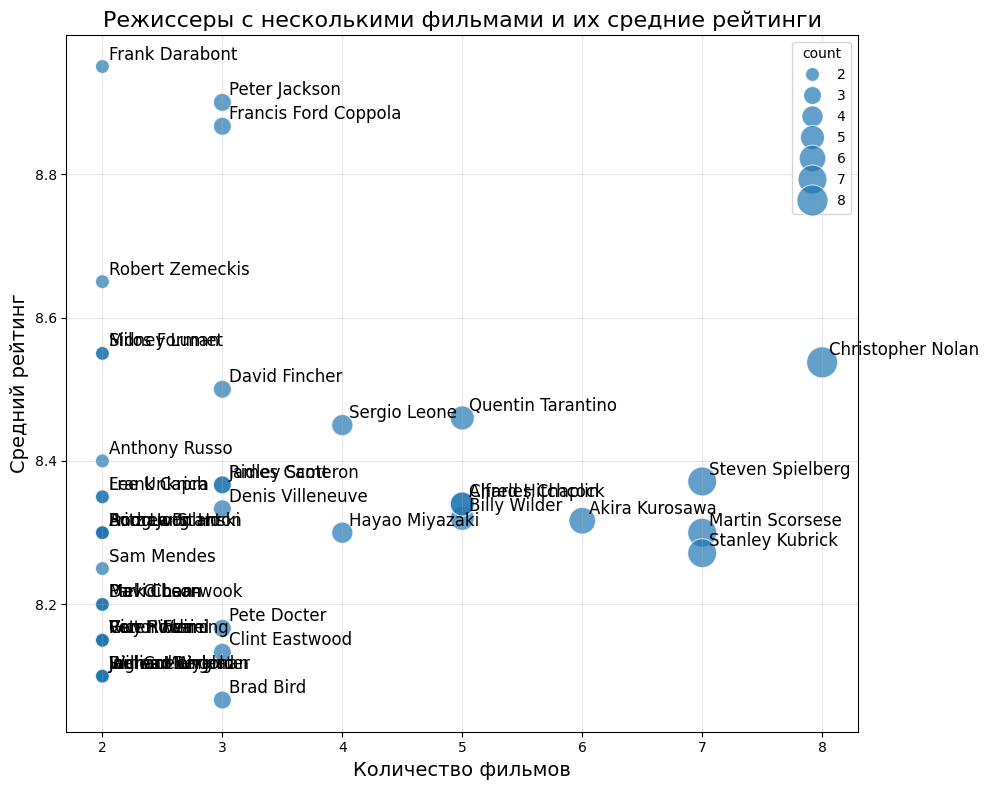

In [34]:
director_counts = df['director'].value_counts()
top_directors = director_counts[director_counts > 1].reset_index()
top_directors.columns = ['director', 'count']

director_ratings = {}
for director in top_directors['director']:
    director_films = df[df['director'] == director]
    avg_rating = director_films['rating'].mean()
    director_ratings[director] = avg_rating

top_directors['avg_rating'] = top_directors['director'].map(director_ratings)
top_directors = top_directors.sort_values('count', ascending=False)

plt.figure(figsize=(10, 8))
sns.scatterplot(x='count', y='avg_rating', data=top_directors, size='count', sizes=(100, 500), alpha=0.7)

for i, row in top_directors.iterrows():
    plt.annotate(row['director'],
                 (row['count'], row['avg_rating']),
                 xytext=(5, 5),
                 textcoords='offset points',
                 fontsize=12)

plt.title('Режиссеры с несколькими фильмами и их средние рейтинги', fontsize=16)
plt.xlabel('Количество фильмов', fontsize=14)
plt.ylabel('Средний рейтинг', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [37]:
bubble_df = genre_ratings_df.copy()
bubble_df['size'] = bubble_df['count'] * 15  # Масштабирование для визуализации

fig = px.scatter(bubble_df, x='count', y='avg_rating', size='size',
                color='genre', hover_name='genre',
                text='genre',
                labels={'count': 'Количество фильмов',
                        'avg_rating': 'Средний рейтинг',
                        'size': 'Популярность жанра'},
                title='Распределение жанров по количеству фильмов и среднему рейтингу')

fig.update_layout(
    xaxis_title='Количество фильмов',
    yaxis_title='Средний рейтинг',
    yaxis_range=[8.4, 9.2],
    legend_title='Жанр',
    width=1000,
    height=600
)

fig.update_traces(
    textposition='top center',
    marker_line_width=1,
    marker_line_color='white'
)

fig.show()

# Основные выводы по результатам исследования фильмов:

## 1. Жанровый анализ
- Драма является доминирующим жанром среди высокорейтинговых фильмов, присутствуя более чем в 60% фильмов из нашей выборки.
- Наиболее высокие средние рейтинги получили фильмы, сочетающие несколько жанров, особенно драма + криминал и драма + биография.
- Фэнтези и приключенческие фильмы также имеют высокие рейтинги, что можно объяснить их эпическим характером и запоминающимися историями.

## 2. Тематический анализ
### Наиболее частые слова

- **find**, **life**, **two**, **one**, **friend**, **help**  
  Эти слова явно выделяются по размеру и указывают на типичные элементы сюжетов:
  - *find* — поиск чего-то/кого-то (частый мотив в драмах, триллерах, приключениях)
  - *life* — жизнь как тема, её сохранение или переосмысление
  - *two*, *one* — отсылают к числу главных героев или дихотомии (две стороны конфликта и т.п.)
  - *friend*, *help* — темы дружбы, поддержки, спасения

---

### Популярные сюжетные элементы

- **Семья и отношения:**  
  Слова *father*, *son*, *wife*, *family*, *mother* указывают на то, что семейные темы важны в описаниях фильмов.

- **Возраст и гендер:**  
  Слова *young*, *old*, *boy*, *girl*, *man*, *woman* — часто описываются персонажи по возрасту и полу, что говорит о важности персонализации.

- **Конфликты и борьба:**  
  *struggle*, *murder*, *war*, *battle*, *police*, *crime*, *violence* — большое внимание уделяется конфликту, преступлениям и насилию.

- **Исторический и политический контекст:**  
  Слова *nazi*, *german*, *american*, *war*, *government*, *veteran* — подчёркивают интерес к историческим событиям (особенно Вторая мировая война).

- **Психология и мотивация:**  
  *tries*, *must*, *lead*, *decide*, *save*, *help*, *become* — подчеркивают внутренние конфликты и мотивацию персонажей.

---

### Часто упоминаемые места и контексты

- *city*, *home*, *school*, *new york*, *empire* — география и окружение также играют заметную роль.

- *future*, *past*, *day*, *year*, *journey* — временные рамки и путешествия во времени/пространстве встречаются часто.

---

## Выводы

1. **Классические темы** вроде дружбы, семьи, борьбы и самопреодоления — доминирующие в описаниях фильмов.
2. **Мотивы конфликта и спасения** (find, save, help, struggle) указывают на драматические или приключенческие жанры.
3. **Исторический контекст и военные темы** (nazi, war, veteran) также часто используются.
4. **Возраст персонажей и их личностные пути** (young, old, become) — важная часть сюжета.

## 3. Режиссерский фактор
### Режиссёры с наивысшим средним рейтингом

- **Frank Darabont** — самый высокий средний рейтинг ≈ 8.9 при всего 2 фильмах.
- **Peter Jackson** и **Francis Ford Coppola** — также имеют высокий средний рейтинг > 8.8 при 3 фильмах.

---

### Режиссёры с наибольшим количеством фильмов

- **Christopher Nolan** — 8 фильмов, средний рейтинг ≈ 8.6. Это один из лучших показателей при большом числе работ.
- **Martin Scorsese**, **Stanley Kubrick**, **Steven Spielberg** — по 7 фильмов, средний рейтинг от 8.2 до 8.4.

---

### Оптимальный баланс количества и качества

- **Christopher Nolan** — лидер по количеству и качеству одновременно.
- **Steven Spielberg** — много фильмов, но немного уступает по среднему рейтингу.
- **Quentin Tarantino** и **Sergio Leone** — 5 фильмов, средний рейтинг 8.4–8.5 — стабильное качество.

---

### Режиссёры с низким средним рейтингом (≈ 8.1–8.2)

- **Brad Bird**, **Clint Eastwood**, **Ron Howard**, **Robert Rodriguez**, **Tim Burton** и другие — имеют от 2 до 4 фильмов с самым низким средним рейтингом среди представленных.

---

### Выводы

1. **Высокий рейтинг чаще встречается у режиссёров с малым числом фильмов**, что может быть связано с тем, что легче поддерживать высокое качество при меньшем объёме работы.
2. **Christopher Nolan** — выдающийся пример стабильного качества при большом количестве фильмов.
3. **Разброс по средней оценке у режиссёров с 2–3 фильмами выше**, чем у тех, кто снял больше — это может указывать на нестабильность